In [2]:
from darts import TimeSeries
import pandas as pd
from darts.models import ExponentialSmoothing
import matplotlib.pyplot as plt
from pylab import rcParams
from darts.metrics import mape
from darts.metrics import mase
import numpy as np

In [3]:
# Read a pandas DataFrame
df = pd.read_csv('../../data/prepared/df_energy_climate_2020.csv')

## Exponential smoothing

In [3]:

# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, 
                                   time_col="datetime",
                                   value_cols=["energy_price"])

splitting_point = (int(len(series)*0.18))

# Set aside the second half of series as a validation series
train, val = series[:-splitting_point], series[-splitting_point:]
# train, val = series.split_before(0.75)

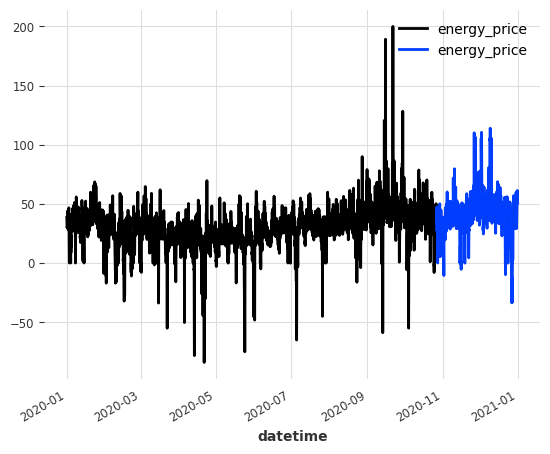

In [4]:
train.plot()
val.plot()

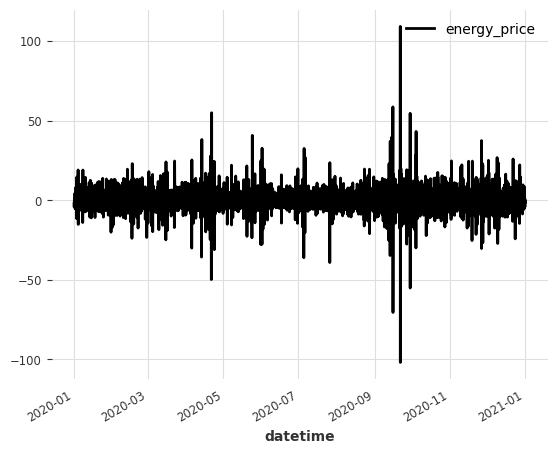

In [5]:
series.diff().plot()

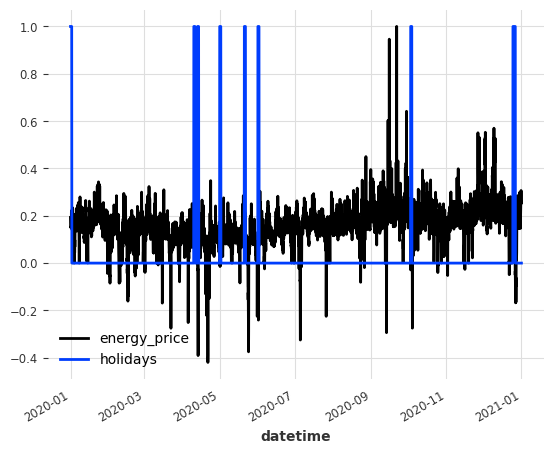

In [6]:
(series / 200).add_holidays('DE').plot()

## Naive baseline models
(useful to get an idea of the bare minumum accuracy that one could expect)

In [7]:
from darts.models import NaiveSeasonal

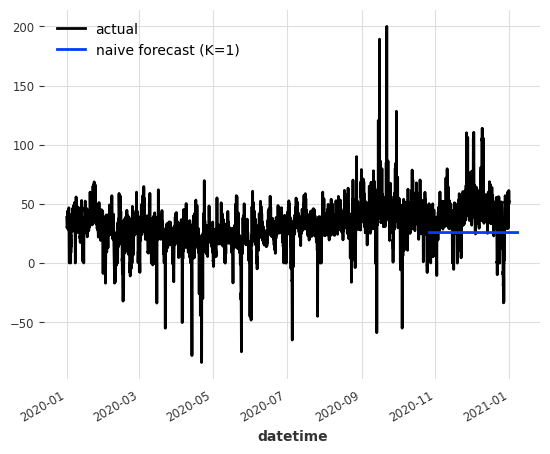

In [8]:
naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(1750)

series.plot(label='actual')
naive_forecast.plot(label='naive forecast (K=1)')

In [9]:
from darts.utils.statistics import plot_acf, check_seasonality

## Hourly seasonality trend

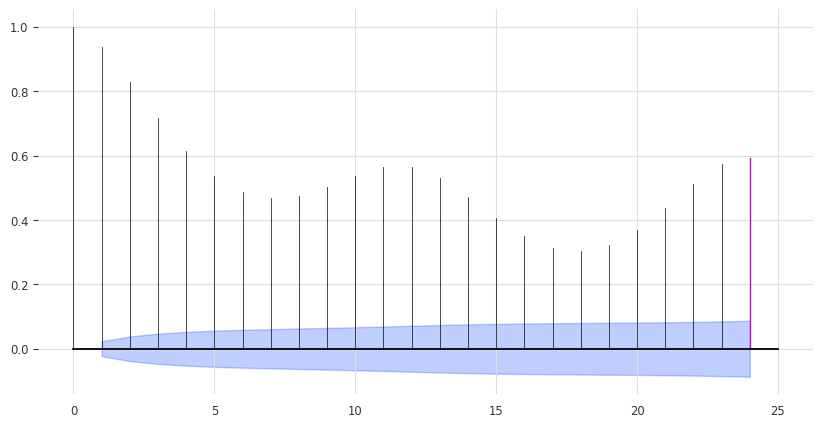

In [10]:
plot_acf(train, m=24, alpha=0.05)
# alpha = confidence level

In [11]:
# run statistical check of seasonality for each candidate period m
for m in range (2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print(f'There is seasonality of order {period}')

There is seasonality of order 12


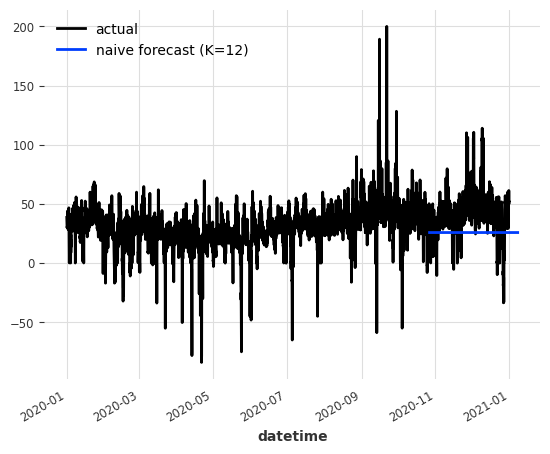

In [12]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(1750)

series.plot(label='actual')
naive_forecast.plot(label='naive forecast (K=12)')

## NaiveDrift (Adding trend)

In [13]:
from darts.models import NaiveDrift

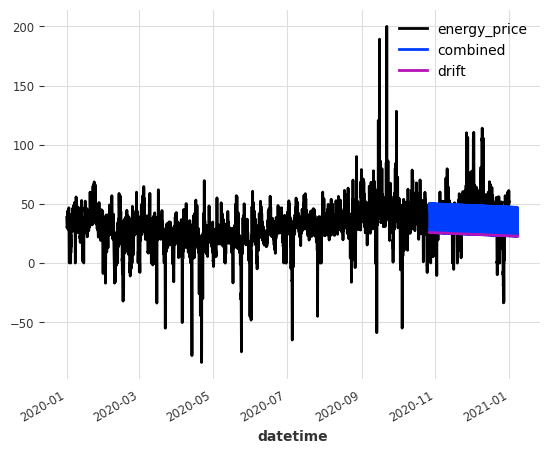

In [14]:
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(1750)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label='combined')
drift_forecast.plot(label='drift')

## Computing error metrics

In [15]:
from darts.metrics import mape

In [16]:
print(f'Mean absolute percentage error for the combined naive drift + seasonal: {mape(series, combined_forecast):.2f}%')

Mean absolute percentage error for the combined naive drift + seasonal: 1183.22%


In [17]:
from darts.models import TBATS, AutoARIMA, Theta

In [18]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print(f'model {model} obtains MAPE: {mape(val, forecast):.2f}')

In [19]:
eval_model(ExponentialSmoothing())
# eval_model(TBATS())
# eval_model(AutoARIMA())
# eval_model(Theta())

model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=24 obtains MAPE: 1053.79


In [20]:
from darts.utils.utils import SeasonalityMode

In [21]:
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float('inf')
best_theta= 0

for theta in thetas:
    model = Theta(theta,
                  season_mode=SeasonalityMode.ADDITIVE
                  )
    model.fit(train)
    pred_theta = model.predict(len(val))
    res=mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [22]:
best_theta_model = Theta(
    best_theta,
    season_mode=SeasonalityMode.ADDITIVE
    )
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(f'The MAPE is: {mape(val, pred_best_theta):.2f} with theta = {best_theta}')

The MAPE is: 742.47 with theta = 0.16326530612244916


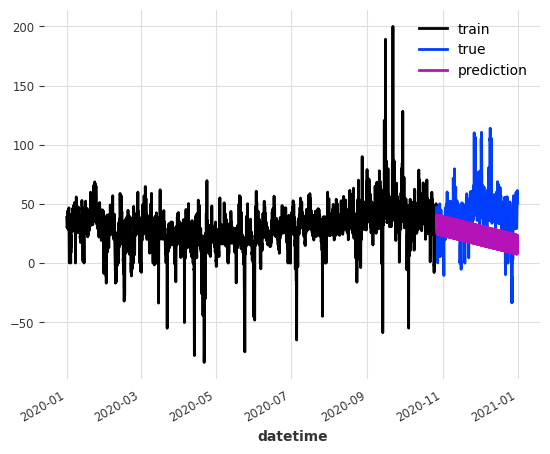

In [23]:
train.plot(label='train')
val.plot(label='true')
pred_best_theta.plot(label='prediction')

## Backtesting

In [24]:
historical_fcast_theta = best_theta_model.historical_forecasts(
    series
)

KeyboardInterrupt: 

MAPE = 51.93%


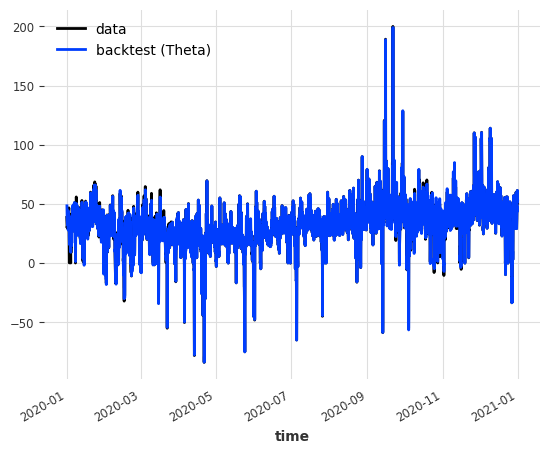

In [ ]:
series.plot(label='data')
historical_fcast_theta.plot(label='backtest (Theta)')
print(f'MAPE = {mape(historical_fcast_theta, series):.2f}%')

In [ ]:
best_theta_model = Theta(best_theta, season_mode=SeasonalityMode.ADDITIVE)

raw_errors = best_theta_model.backtest(
    series, 
    start=0.6,
    forecast_horizon=3,
    metric=mape,
    reduction=None,
    verbose=True    
)

from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arrange(0, max(raw_errors), 1),
    title='Indivisdual backtest error scores (histogram)'
)

In [ ]:
from darts.utils.statistics import plot_residuals_analysis

In [ ]:
plot_residuals_analysis(best_theta_model.residuals(series))

In [26]:

model_es = ExponentialSmoothing()
historical_fcast_es = model_es.historical_forecasts(
    series, start=0.95, forecast_horizon=168, verbose=True)
series.plot(label='data')
historical_fcast_es.plot(label='backtest (Exp. Smoothing)')
print(f'MAPE = {mape(historical_fcast_es, series):.2f}%')
model.fit(train)
#  Number of times a prediction is sampled from a probabilistic model. Should be left set to 1 for deterministic models.
prediction = model.predict(len(val))

  0%|          | 0/3348 [00:00<?, ?it/s]

KeyboardInterrupt: 

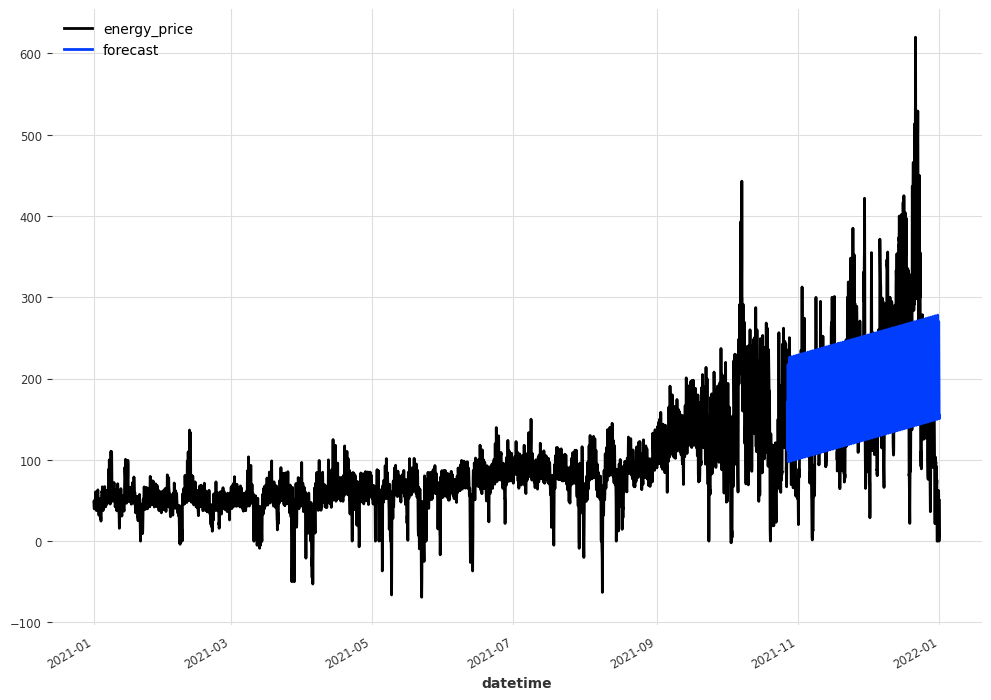

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
series.plot()
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

## Evaluation

- MAPE (Mean Absolute Percentage Error)
    - < 10 %: very good
    - 10% - 20%: Good
    - 20% - 50%: OK
    - \> 50%: Not good

- MASE (Mean Absolute Scaled Error)
    - 0.0: best score
    - \> 1: the model needs a lot of improvement



In [ ]:
score_mape = mape(val, prediction)
score_mape

2480.0265676289223

In [ ]:
score_mase = mase(val, prediction, train)
score_mase

9.90943256172074